# Deteksi Penipuan (Fraud) Kartu Kredit  
**Model:** Logistic Regression (baseline) vs XGBoost (advanced)  
**Dataset:** `creditcard.csv` (Kaggle Credit Card Fraud Detection)

Versi ini menggunakan **SMOTETomek** untuk menyeimbangkan **data TRAIN saja** (tanpa data leakage ke validation/test) dan **tanpa threshold tuning / tanpa menyimpan threshold**.

> Jika menjalankan di environment yang belum punya `xgboost` / `imbalanced-learn`, jalankan:
```bash
pip install xgboost imbalanced-learn
```

## 0) Setup & Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report,
    roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score,
    average_precision_score, precision_recall_curve
)

import joblib
import warnings
warnings.filterwarnings("ignore")

# Imbalanced-learn (SMOTETomek) — dipakai di TRAIN saja melalui pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek

# XGBoost
try:
    from xgboost import XGBClassifier
except Exception as e:
    XGBClassifier = None
    print("XGBoost belum tersedia. Install dulu: pip install xgboost")
    print("Error:", e)

RANDOM_STATE = 42


## 1) Load Dataset

In [2]:
DATA_PATH = "creditcard.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (20000, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 2) Data Cleaning (Duplicates & Missing Values)

In [3]:
missing_total = int(df.isna().sum().sum())
dupes_total = int(df.duplicated().sum())

print("Total missing values:", missing_total)
print("Total duplicated rows:", dupes_total)

if dupes_total > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    missing_total = int(df.isna().sum().sum())
    print("Duplikat dihapus. Shape baru:", df.shape)
else:
    print("Tidak ada duplikasi.")

if missing_total == 0:
    print("Tidak ada missing values.")
else:
    print("Ada missing values. Pertimbangkan imputasi sesuai kebutuhan.")


Total missing values: 0
Total duplicated rows: 69
Duplikat dihapus. Shape baru: (19931, 31)
Tidak ada missing values.


## 3) Split Feature/Target

In [4]:
target_col = "Class"
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

print("X shape:", X.shape)
print("y positive rate (fraud=1):", float(y.mean()))


X shape: (19931, 30)
y positive rate (fraud=1): 0.004264713260749586


## 4) Train/Validation/Test Split (Stratified)

In [5]:
# (Validation disiapkan, tetapi versi ini tidak melakukan threshold tuning)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.25, stratify=y_train_full, random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Val size:", X_val.shape, "Test size:", X_test.shape)
print("Train fraud rate:", float(y_train.mean()))
print("Val fraud rate  :", float(y_val.mean()))
print("Test fraud rate :", float(y_test.mean()))


Train size: (11958, 30) Val size: (3986, 30) Test size: (3987, 30)
Train fraud rate: 0.004264927245358756
Val fraud rate  : 0.004264927245358756
Test fraud rate : 0.004263857536995234


## 5) Preprocessing (Scaling Amount)

In [6]:
# IMPORTANT: preprocess harus didefinisikan sebelum dipakai untuk visualisasi sesudah SMOTE.
scale_cols = ["Amount"]
passthrough_cols = [c for c in X.columns if c not in scale_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("scale", RobustScaler(), scale_cols),
        ("pass", "passthrough", passthrough_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


## 6) Distribusi Label Kelas (Train) — Sebelum vs Sesudah SMOTE

Distribusi Sebelum SMOTE (TRAIN asli):


Class
0    11907
1       51
Name: count, dtype: int64

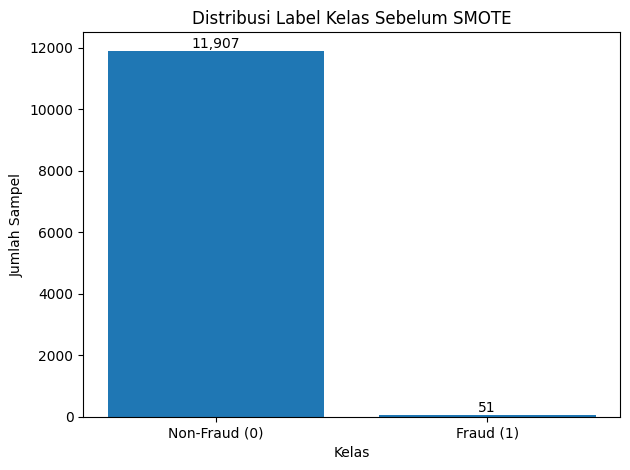

  File "c:\Users\Purnamasari Siregar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\Purnamasari Siregar\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\Purnamasari Siregar\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Purnamasari Siregar\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,



Distribusi Sesudah SMOTE (TRAIN setelah preprocess):


Class
0    11888
1    11888
Name: count, dtype: int64

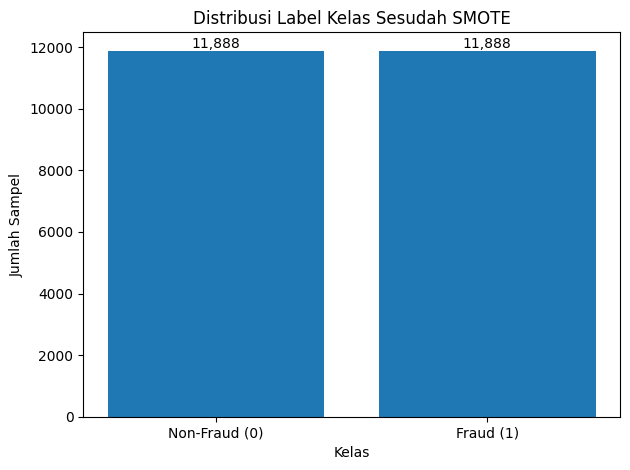

In [7]:
labels = ["Non-Fraud (0)", "Fraud (1)"]

# --- Sebelum SMOTE (train asli) ---
counts_before = y_train.value_counts().sort_index()
print("Distribusi Sebelum SMOTE (TRAIN asli):")
display(counts_before)

plt.figure()
bars = plt.bar(labels, counts_before.values)
plt.title("Distribusi Label Kelas Sebelum SMOTE")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
for bar, val in zip(bars, counts_before.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{int(val):,}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# --- Sesudah SMOTE (train yang sudah dipreprocess) ---
# Samakan urutan dengan pipeline: preprocess dulu, baru SMOTETomek
sampler_vis = SMOTETomek(random_state=RANDOM_STATE)

# Fit preprocessing hanya pada TRAIN (tidak leakage)
X_train_pre = preprocess.fit_transform(X_train)

# Resample pada hasil preprocess (sesuai pipeline)
X_train_res, y_train_res = sampler_vis.fit_resample(X_train_pre, y_train)

counts_after = pd.Series(y_train_res).value_counts().sort_index()
print("\nDistribusi Sesudah SMOTE (TRAIN setelah preprocess):")
display(counts_after)

plt.figure()
bars = plt.bar(labels, counts_after.values)
plt.title("Distribusi Label Kelas Sesudah SMOTE")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
for bar, val in zip(bars, counts_after.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{int(val):,}", ha="center", va="bottom")
plt.tight_layout()
plt.show()


## 7) EDA Singkat (Distribusi Fitur Utama)

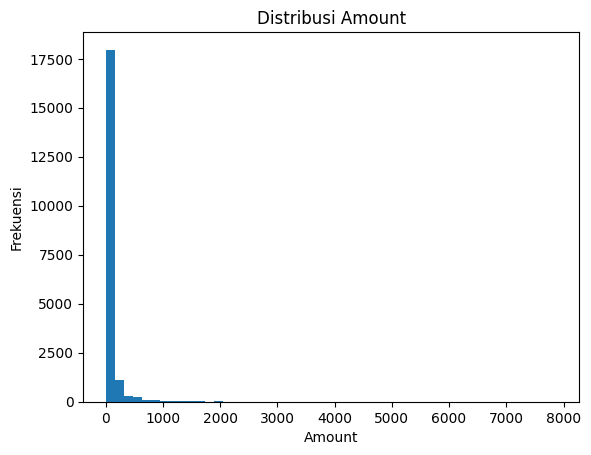

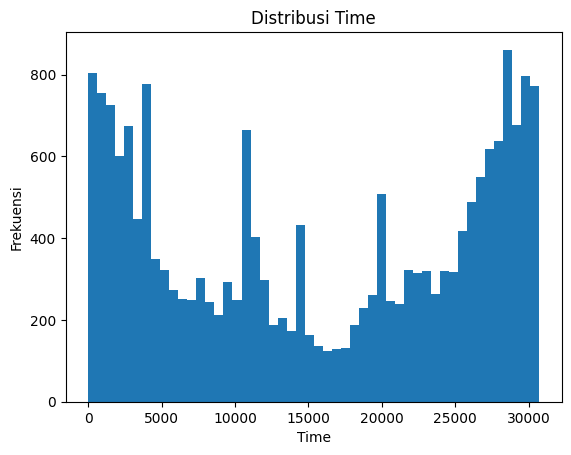

In [8]:
plt.figure()
plt.hist(df["Amount"], bins=50)
plt.title("Distribusi Amount")
plt.xlabel("Amount")
plt.ylabel("Frekuensi")
plt.show()

plt.figure()
plt.hist(df["Time"], bins=50)
plt.title("Distribusi Time")
plt.xlabel("Time")
plt.ylabel("Frekuensi")
plt.show()


## 8) Helper Function Evaluasi (Tanpa Threshold Tuning)

In [9]:
def evaluate_model(name, model, X_eval, y_true, plot=True):
    """Evaluasi model imbalanced tanpa threshold tuning (pakai model.predict default)."""
    y_pred = model.predict(X_eval)            # default decision rule (umumnya proba >= 0.5)
    y_proba = model.predict_proba(X_eval)[:, 1]

    prec = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"\n{name} (default decision rule)")
    print(f"Precision (fraud=1): {prec:.6f}")
    print(f"Recall    (fraud=1): {rec:.6f}")
    print(f"F1-score  (fraud=1): {f1:.6f}")
    print(f"ROC-AUC           : {roc_auc:.6f}")
    print(f"PR-AUC (AvgPrec)  : {pr_auc:.6f}\n")

    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=6))

    if plot:
        cm = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
        plt.title(f"Confusion Matrix - {name}")
        plt.show()

        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

        p, r, _ = precision_recall_curve(y_true, y_proba)
        plt.figure()
        plt.plot(r, p, label=f"{name} (PR-AUC={pr_auc:.4f})")
        plt.title(f"Precision-Recall Curve - {name}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.show()

    return {
        "Model": name,
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "ROC_AUC": float(roc_auc),
        "PR_AUC": float(pr_auc),
    }


## 9) Model 1 — Logistic Regression + SMOTETomek


Logistic Regression (default decision rule)
Precision (fraud=1): 0.340909
Recall    (fraud=1): 0.882353
F1-score  (fraud=1): 0.491803
ROC-AUC           : 0.995703
PR-AUC (AvgPrec)  : 0.564131

Classification report:
              precision    recall  f1-score   support

           0   0.999493  0.992695  0.996082      3970
           1   0.340909  0.882353  0.491803        17

    accuracy                       0.992225      3987
   macro avg   0.670201  0.937524  0.743943      3987
weighted avg   0.996685  0.992225  0.993932      3987



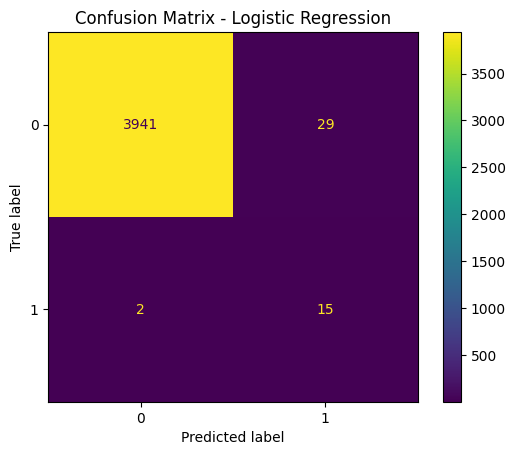

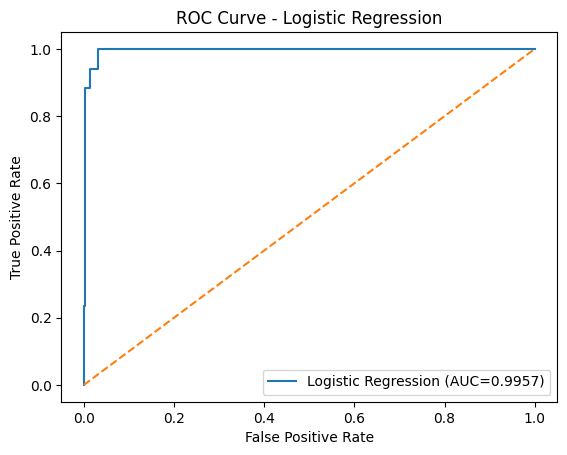

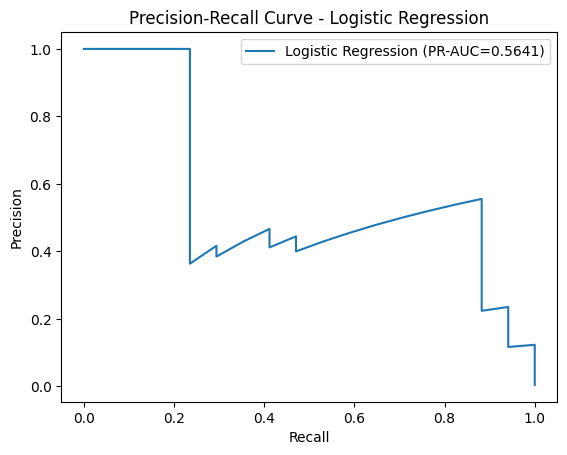

In [10]:
sampler_lr = SMOTETomek(random_state=RANDOM_STATE)

lr_clf = LogisticRegression(
    max_iter=5000,
    class_weight=None,  # jangan dobel karena sudah pakai sampler
    random_state=RANDOM_STATE
)

lr_pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("sampler", sampler_lr),
    ("model", lr_clf)
])

lr_pipe.fit(X_train, y_train)
lr_metrics_test = evaluate_model("Logistic Regression", lr_pipe, X_test, y_test, plot=True)


## 10) Model 2 — XGBoost + SMOTETomek


XGBoost (default decision rule)
Precision (fraud=1): 0.882353
Recall    (fraud=1): 0.882353
F1-score  (fraud=1): 0.882353
ROC-AUC           : 0.999778
PR-AUC (AvgPrec)  : 0.959573

Classification report:
              precision    recall  f1-score   support

           0   0.999496  0.999496  0.999496      3970
           1   0.882353  0.882353  0.882353        17

    accuracy                       0.998997      3987
   macro avg   0.940925  0.940925  0.940925      3987
weighted avg   0.998997  0.998997  0.998997      3987



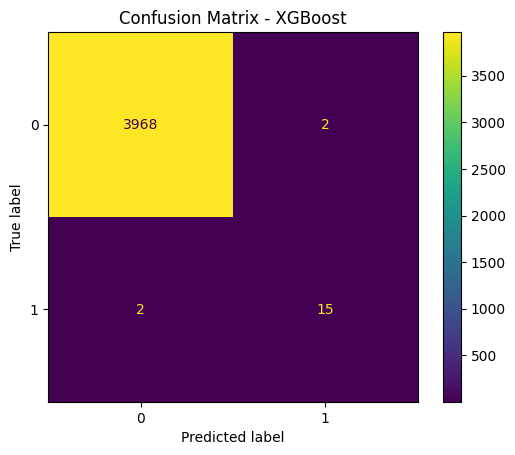

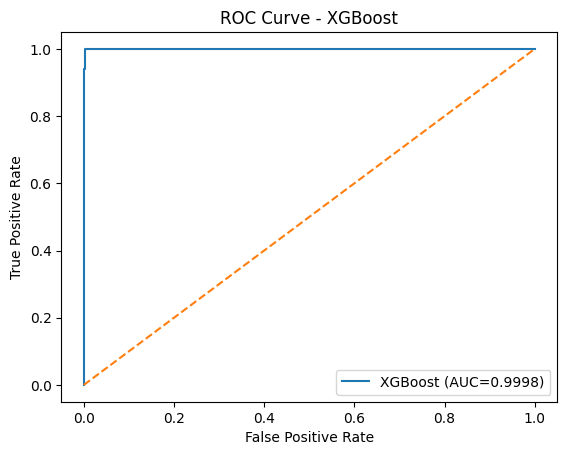

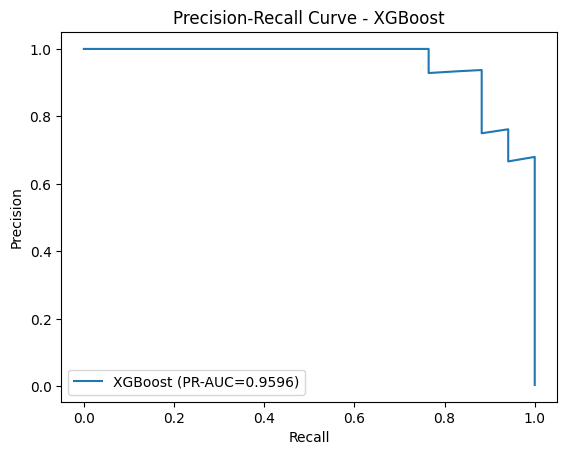

In [11]:
if XGBClassifier is None:
    raise RuntimeError("XGBoost tidak tersedia. Install dulu: pip install xgboost")

sampler_xgb = SMOTETomek(random_state=RANDOM_STATE)

xgb_clf = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric="aucpr"
)

xgb_pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("sampler", sampler_xgb),
    ("model", xgb_clf)
])

xgb_pipe.fit(X_train, y_train)
xgb_metrics_test = evaluate_model("XGBoost", xgb_pipe, X_test, y_test, plot=True)


## 11) Perbandingan Model (Test Set)

In [12]:
results = pd.DataFrame([lr_metrics_test, xgb_metrics_test]).sort_values(by="F1", ascending=False)
display(results)


,Model,Precision,Recall,F1,ROC_AUC,PR_AUC
1,XGBoost,0.882353,0.882353,0.882353,0.999778,0.959573
0,Logistic Regression,0.340909,0.882353,0.491803,0.995703,0.564131


## 12) Pilih Model Terbaik untuk Deployment (tanpa threshold)

In [13]:
best_row = results.sort_values("F1", ascending=False).iloc[0]
best_name = best_row["Model"]
print("Best model:", best_name)

best_model = lr_pipe if best_name == "Logistic Regression" else xgb_pipe


Best model: XGBoost


## 13) Interpretasi Model (Feature Importance / Coefficient)

,feature,importance
15,V14,0.531287
11,V10,0.272779
5,V4,0.050872
13,V12,0.023023
3,V2,0.020550
7,V6,0.013613
21,V20,0.010848
8,V7,0.010756
18,V17,0.010345
10,V9,0.007237


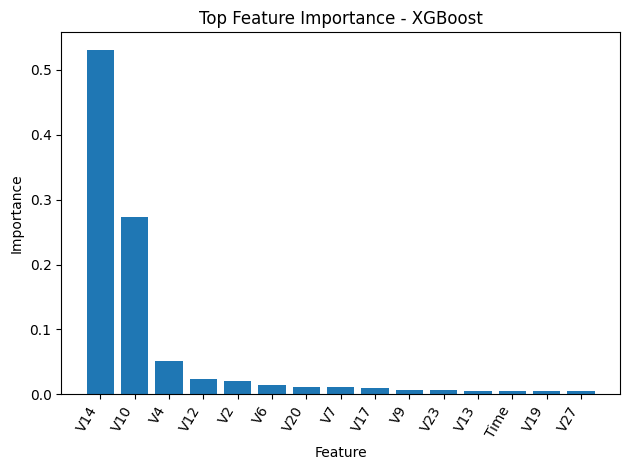

In [14]:
# Ambil nama fitur dari pipeline yang SUDAH fit (lebih aman)
feature_names = best_model.named_steps["prep"].get_feature_names_out()
topk = 15

if best_name == "XGBoost":
    booster = best_model.named_steps["model"]
    importances = booster.feature_importances_
    fi = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
    display(fi.head(topk))

    plt.figure()
    plt.bar(fi["feature"].head(topk), fi["importance"].head(topk))
    plt.title("Top Feature Importance - XGBoost")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()
else:
    lr_model = best_model.named_steps["model"]
    coefs = lr_model.coef_.ravel()

    coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
    coef_df["abs_coef"] = coef_df["coef"].abs()
    coef_df = coef_df.sort_values("abs_coef", ascending=False)
    display(coef_df.head(topk))

    plt.figure()
    plt.bar(coef_df["feature"].head(topk), coef_df["abs_coef"].head(topk))
    plt.title("Top |Coefficient| - Logistic Regression")
    plt.xlabel("Feature")
    plt.ylabel("|coef|")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()


## 14) Simpan Model Terbaik (Wajib) — tanpa threshold

In [15]:
MODEL_OUT = "fraud_model.joblib"
joblib.dump(best_model, MODEL_OUT)
print("Saved model to:", MODEL_OUT)


Saved model to: fraud_model.joblib


## 15) Contoh Prediksi 1 Baris (Simulasi Input Streamlit) — tanpa threshold

In [16]:
sample = X_test.iloc[[0]].copy()
pred_proba = best_model.predict_proba(sample)[0, 1]
pred_class = int(best_model.predict(sample)[0])

print("Sample prediction:")
print("Predicted probability (fraud=1):", float(pred_proba))
print("Predicted class (model.predict):", pred_class)


Sample prediction:
Predicted probability (fraud=1): 3.983241185778752e-05
Predicted class (model.predict): 0
